In [2]:
import os
import math
import keras
import pydicom
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Input, 
                                     Conv2D,
                                     GlobalMaxPooling2D,
                                     MaxPooling2D,
                                     Dropout, 
                                     Dense)

https://www.tensorflow.org/api_docs/python/tf/keras/utils/PyDataset

<font size=4.4>

The magic of the class is the __getitem__ dunder method, which "creates" the new batches of data for the model.
In reality, it is not creating but rather grabbing the data from the data that was passed to the class and performing 
some manipulations on it. Such as normalizing the pixel values between 0-1, making sure all images are in the same 
format, and resizes the images to a specific size using nearest-neighbor interpolation, and allowing a new
dimension for the color channel to be specified in the image.

</font>

In [3]:
imgShape = (256, 256, 1)
folder = '/mnt/c/Users/vange/OneDrive - Tennessee Tech University/Desktop/Fall 23, Spring 24/4260/mammography'


class BatchCreator(Sequence):

    def __init__(self, data, dataType, batchSize, workers = 8, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.batchSize = batchSize
        
        if dataType == 1:
            self.dataType = 'train'
            
        else:
            self.dataType = 'test'


    # returns the number of batches in the dataset 
    def __len__(self):
        return math.ceil(len(self.data) / self.batchSize)

    def __getitem__(self, index):
        # calculates the beginning and end indices for the batch based on the batch size and the index
        start = index * self.batchSize
        end = min(start + self.batchSize, len(self.data))
        
        # initializes arrays to hold the input images and labels for the batch
        inputImages = np.zeros((self.batchSize, ) + imgShape)        
        labels = np.zeros((self.batchSize, 1))

        # iterates over the indices of the current batch, stops if the index exceeds the length of the dataset
        for i, idx in enumerate(range(start, end)):          
            if index >= len(self.data):
                break
                
            patientID = self.data.iloc[idx]['patient_id']
            imgID = self.data.iloc[idx]['image_id']
            
            fileName = os.path.join(folder, f"{self.dataType}_images", str(patientID), f"{imgID}.dcm")
            image = pydicom.dcmread(fileName)
            images = image.pixel_array

            # normalizing pixel values [0, 1]
            images = minmax_scale(images)

            # Many images are in MONOCHROME1 format, we however need all in MONOCHROME2 format since 0 is black instead
            # of white like in MONOCRHOME1. This ensures that our dark areas in the images are actually dark and that
            # the bright areas are actually bright, in its original form, the opposite is true.
            if image.PhotometricInterpretation == "MONOCHROME1":
                images = 1 - images

            # resizes the image using nearest-neighbor interpolation and converts it to a nparray
            images = tf.image.resize(images = np.expand_dims(images, axis = -1), size = imgShape[:-1], method='nearest').numpy()

            # assigns the processed image to the inputImages array at index i
            inputImages[i, :, :, 0] = images.squeeze()
            
            if self.dataType == 'train':
                # assigns the label to the labels array at index i
                labels[i] = self.data.iloc[idx]['cancer']
            
        if self.dataType == 'train':
            return (inputImages, labels)
        
        else: 
            return inputImages

<font size=4.4>
In the cell below, we iterate over the data that are cancer positive and filter them out and then take a subset
of the rest of the data equal in length to that of the cancer count, finally appending it to a new list.
</font>

In [4]:
trainData = pd.read_csv("/mnt/c/Users/vange/OneDrive - Tennessee Tech University/Desktop/Fall 23, Spring 24/4260/mammography/train.csv")
newTrainData = []

# counts each unique cancer value
cancerCount = trainData.cancer.value_counts()

# prevents oversampling of patients with and without cancer, we use all available true cancer patients
# and sample the rest of the dataset to get the same amount of noncancerous patients
for i, placeholder in cancerCount.items():
    filteredData = trainData[trainData['cancer'] == i]
    sampledData = filteredData.sample(cancerCount[1])
    newTrainData.append(sampledData)

trainDF = pd.concat(newTrainData)

# gives 2316, we have 1158 true cancer patients, so we grab 1158 false cancer patients
len(trainDF)

2316

In [5]:
from sklearn.model_selection import train_test_split

xTrain, xVal = train_test_split(trainDF, test_size = 0.20, random_state = 1)
len(xTrain), len(xVal)

(1852, 464)

#### 13 was the largest batch size that did not cause memory errors, if a better GPU was aquired, a higher batch size could be used.

In [10]:
gendTrain = BatchCreator(xTrain, 1, 13)
gendVal = BatchCreator(xVal, 1, 13)

#### Start with 32 filters and scale by 2 each layer, except for the layer following the next each time
#### MaxPooling2d will downsample helping reduce computations, can also help overfitting and model efficiency
#### Dropout randomly sets 30% of input to 0 to reduce overfitting, repeat these multiple times
#### Dense layer used to learn non-linear combinations of the features
#### Output layer, sigmoid activation function for binary classification
#### Using recall and precision with different thresholds to see performance at different points

In [8]:
imgShape = (256, 256, 1)
model = Sequential()

model.add(Input(shape = imgShape))

model.add(Conv2D(32, (5, 5), activation = "relu"))
model.add(Conv2D(64, (5, 5), activation = "relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(64, (5, 5), activation = "relu"))
model.add(Conv2D(128, (5, 5), activation = "relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, (5, 5), activation = "relu"))
model.add(Conv2D(256, (5, 5), activation = "relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(GlobalMaxPooling2D())
model.add(Dropout(0.3))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = Adam(learning_rate = 0.0005), loss = 'binary_crossentropy',
              metrics = [tf.keras.metrics.BinaryAccuracy(threshold = 0.5),
                         tf.keras.metrics.Recall(thresholds = [0.4, 0.5, 0.6]),
                         tf.keras.metrics.Precision(thresholds = [0.4, 0.5, 0.6])])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 252, 252, 32)      832       
                                                                 
 conv2d_7 (Conv2D)           (None, 248, 248, 64)      51264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 124, 124, 64)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 124, 124, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 120, 120, 64)      102464    
                                                                 
 conv2d_9 (Conv2D)           (None, 116, 116, 128)     204928    
                                                      

#### Below we fit the model on 14 epochs, this was done since it takes about 9ish hours, being the max we were willing to train for for the final model.

#### This however may have been quite a waste as we can see a flatline in performace from epoch 7 - 12, so we could have cut back on the epoch numbers, however this was the first and only time that training was done on an epoch higher than 4 simply due to time and hardware constrains.

#### Future implementations could be a more layered model with a different learning rate since there was a flatline. This may fix that issue entirely, but we are unsure whether this is the reason of the flatline or if there is something else.

In [11]:
# loss = quantified value of how well the model is predicting vs the actual value, we want a low number
# binary accuracy = percentage of correct predictions
# recall = % of true + over all + predictions (true and false +) accuracy of the + predictions
# precision = % of true + out of all + (true + and false -) ability of model to find all + samples
# f1score = balance between recall and precision, we want high number


history = model.fit(gendTrain, validation_data = gendVal, epochs = 14)

Epoch 1/14
143/143 [==============================] - 2322s 16s/step - loss: 0.6940 - binary_accuracy: 0.4933 - recall_1: 0.4022 - precision_1: 0.3219 - val_loss: 0.6933 - val_binary_accuracy: 0.4893 - val_recall_1: 0.3333 - val_precision_1: 0.1702
Epoch 2/14
143/143 [==============================] - 2205s 15s/step - loss: 0.6928 - binary_accuracy: 0.5186 - recall_1: 0.4389 - precision_1: 0.5322 - val_loss: 0.6935 - val_binary_accuracy: 0.4893 - val_recall_1: 0.3333 - val_precision_1: 0.1702
Epoch 3/14
143/143 [==============================] - 2027s 14s/step - loss: 0.6935 - binary_accuracy: 0.5024 - recall_1: 0.3359 - precision_1: 0.2815 - val_loss: 0.6933 - val_binary_accuracy: 0.4893 - val_recall_1: 0.3333 - val_precision_1: 0.1702
Epoch 4/14
143/143 [==============================] - 2040s 14s/step - loss: 0.6944 - binary_accuracy: 0.4917 - recall_1: 0.4120 - precision_1: 0.3230 - val_loss: 0.6932 - val_binary_accuracy: 0.4893 - val_recall_1: 0.3333 - val_precision_1: 0.1702
Epoc

#### Here the F1Score is calculated, the result is based on the 3 different thresholds that were passed to precision and recall in the model.

#### We see an F1Score of 0.3677 which is not horrible given the weird flatline error that happened in training. 
#### If those errors were to not have occured, we would probably see an F1Score that is slightly higher, maybe a bit closer to what the accuracy score is.

In [80]:
import numpy as np

def f1Score(precision, recall):
    # Change all NANS to 0
    precision = np.nan_to_num(precision)
    recall = np.nan_to_num(recall)
    
    # Calculate f1 score and make sure the denominator is never 0
    denominator = precision + recall
    f1 = np.where(denominator == 0, 0, 2 * (precision * recall))
    
    return np.nanmean(f1)

# Loop through all epochs and calculate the f1 score values from the 3 different
# recall and precision thresholds that we had specified in the model
for epoch, (precision, recall) in enumerate(zip(history.history["precision_1"], history.history["recall_1"]), 1):
    f1 = f1Score(precision, recall)

f1

0.3677316

#### In the graph below, we graph the loss vs val_loss against all the epochs and begin seeing a convergence near epoch 7.

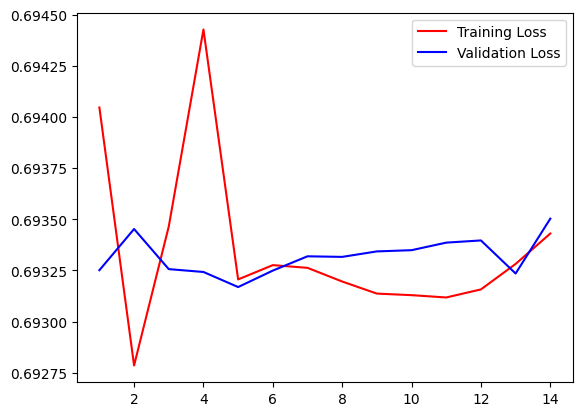

In [119]:
epochs = range(1, 15)

plt.plot(epochs, history.history['loss'], 'r', label = 'Training Loss')
plt.plot(epochs, history.history['val_loss'], 'b', label = 'Validation Loss')
plt.legend()

plt.show()

#### However for the next plots, we see the validation error in play, being a flat line the entire time.
#### We also all recall values performing quite weirdly, especially 0.4 and 0.6, those did not work out great.
#### Unfortunately we forgot to plot the precision, but it was the same as recall since the values were impacted the same as recalls, if we want to plot recall, we would have to retrain the whole model.

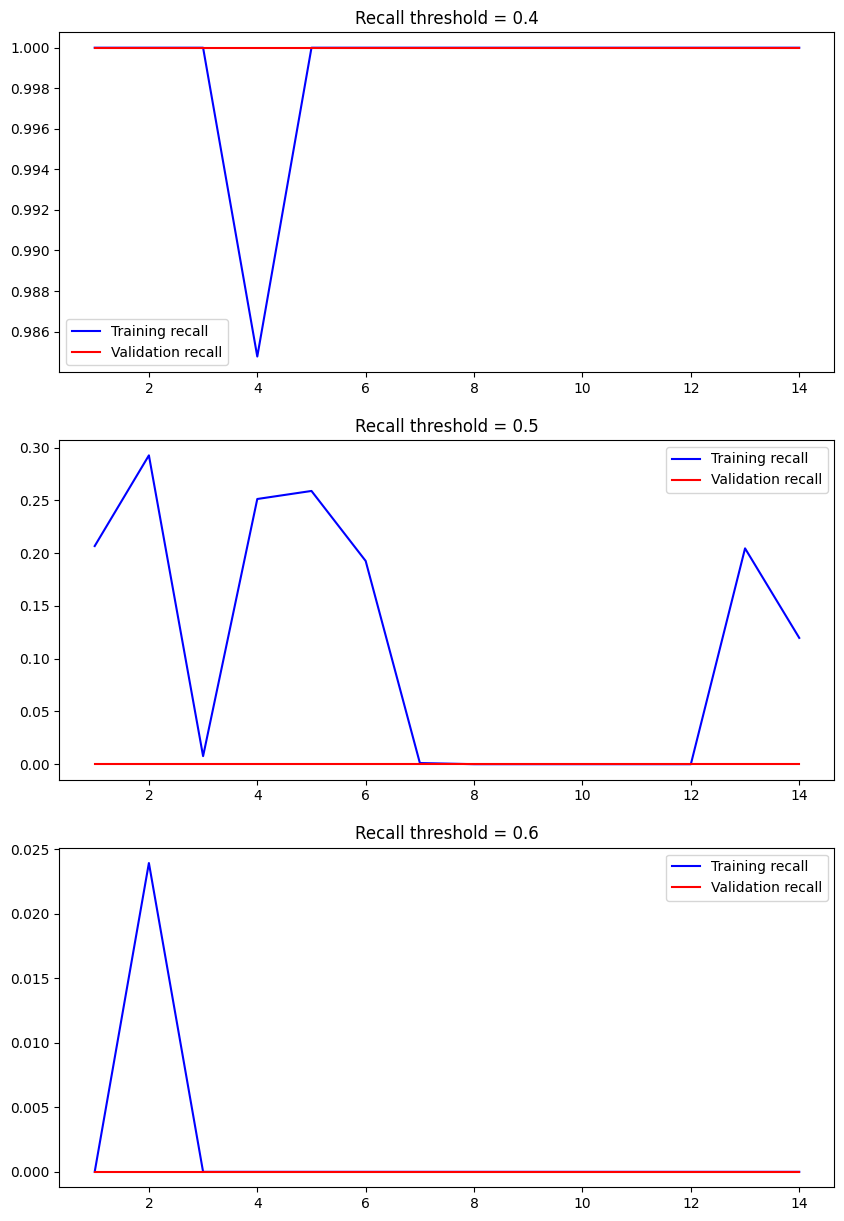

In [205]:
recall = np.array(history.history['recall_1'])
valRecall = np.array(history.history['val_recall_1'])

thresholds = [0.4, 0.5, 0.6]
plt.figure(figsize=(10, 5 * 3))

for i, threshold in enumerate(thresholds):
    plt.subplot(3, 1, i + 1)
    plt.plot(range(1, 15), recall[:, i], 'b', label='Training recall')
    plt.plot(range(1, 15), valRecall[:, i], 'r', label='Validation recall')
    plt.title(f'Recall threshold = {threshold}')
    plt.legend()

plt.show()


In [14]:
testData = pd.read_csv("/mnt/c/Users/vange/OneDrive - Tennessee Tech University/Desktop/Fall 23, Spring 24/4260/mammography/test.csv")
testData

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


#### Here we grab our test data and predict on it, a mistake here was using 13 batches, only 4 were needed with 4 different images.

#### This resulted in 9 extra predicition results, but we can filter them out as we do in the next cell.

In [40]:
gendTest = BatchCreator(testData, 2, 13)
pred = model.predict(gendTest)

1/1 [==============================] - 4s 4s/step


In [197]:
# Here we can see the 4 prediction, since I forgot to do a batch size of 4, there are
# a bunch of random predictions, 13 in total, however we need only the first 4 since
# those are the predictions that coorespond to the 4 images

sorted(pred, reverse = True)[:4]

[array([0.49373135], dtype=float32),
 array([0.49372953], dtype=float32),
 array([0.49372], dtype=float32),
 array([0.49371466], dtype=float32)]

#### Here we append the predicted values to the test data, we see a predicted value of 0.49 for both left and right breasts.

#### This turned out to be a rather decent model despite the weird validation data error and a few precision and recall values being messed up.
#### Those of course do not impact the model's performance for if it learns, it learns, but when wanting to look at the metrics, it makes it harder.

In [103]:
# Assigning the prediction values to a cancer column on the test data

testData['cancer'] = pred[:testData.shape[0]]
testData

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10008,736471439,L,MLO,81,0,21,10008_L,0.493731
1,2,10008,1591370361,L,CC,81,0,21,10008_L,0.493730
2,2,10008,68070693,R,MLO,81,0,21,10008_R,0.493720
3,2,10008,361203119,R,CC,81,0,21,10008_R,0.493715


#### Finally we create the aggregated dataframe, print the results, and save the model incase we wish to use it later.

In [201]:
# The left breast according to the model has a 0.49% chance of being cancerous,
# only a ten-thousandth more than the right breasts chance of being cancerous.

final = testData.groupby('prediction_id')['cancer'].agg('max').reset_index()
final

,prediction_id,cancer
0,10008_L,0.493731
1,10008_R,0.493720


In [15]:
model.save('model.keras')

In [36]:
model = keras.models.load_model('model.keras')